# CAPSTONE

To create a recommender model to assist the Sales & Marketing Department in identifying cross-selling opportunities to our customers through identifying customer segments by applying clustering techniques on customer sales data, including natural language processing of product descriptions to identify product categories.

Deliverables: to deliver a recommender model that improves by at least 10% accuracy from baseline model without feature engineering.

Customer Segementation by 
- RFM: (Recency, Frequency, Monetary) using K-means/DBScan/Hierarchical clustering
https://www.optimove.com/resources/learning-center/customer-segmentation-via-cluster-analysis#:~:text=In%20the%20context%20of%20customer,archetypes%E2%80%9D%20or%20%E2%80%9Cpersonas%E2%80%9D.

https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/

https://www.shopify.com.sg/encyclopedia/customer-segmentation#:~:text=Customer%20segmentation%20is%20the%20process,Number%20of%20employees


https://analyticsindiamag.com/how-to-measure-the-success-of-a-recommendation-system/

https://www.kaggle.com/code/azizozmen/customer-segmentation-cohort-rfm-analysis-k-means

https://www.kaggle.com/code/ozlemilgun/customer-segmentation-using-rfm-analysis

https://www.kaggle.com/code/mathchi/business-problem-with-customer-segmentation

- Product segmentation (categorical) using K modes, Jacard Distance
Categorize products into main categories by performing NLP on product description (parts of speech tagging)

https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/#:~:text=KModes%20clustering%20is%20one%20of,similar%20our%20data%20points%20are.

- Clustering of combination of categorical and numerical features (Gower Distance, Dimensionality Reduction Techniques, K-prototypes)

Dataset only has 8 columns. Segmentation would require feature engineering to identify additional features for clustering. 

Unique product descriptions are about 4000+, which detail product type and variants like colour, design, and number of items it contains.

We would use RFM (Recency, Frequency, Monetary) Analysis to numerical sales data 

8 feature columns, 540K observations
'InvoiceNo' - 25900 unique
'stockcode_caps' - 4070 unique
'description_new' - 4223 unique, includes adjustment entries like stock returns, discounts 
'Quantity'
'InvoiceDate' - 1 year period
'UnitPrice'
'CustomerID' - 4372 unique
'Country' - 38 countries, 91% from one country

Assume average gross margin is 42%, net margin is 7% - online retail
https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/margin.html

https://en.wikipedia.org/wiki/List_of_countries_by_United_Nations_geoscheme

1. What is your problem statement?  What will you actually be doing?

2. Who is your audience?  Why will they care?
 
3. What is your success metric?  How will you know if you are actually solving the problem in a useful way?

4. What is your data source?  What format is your data in?  How much cleaning and munging will be required?

5. What are potential challenges or obstacles and how will you mitigate them?

6. Is this a reasonable project given the time constraints that you have?



Week starting 25 Apr
First half
- Import and clean data
- NLP of product categories
- EDA on product categories
- Product category clustering - K modes
- Create basic recommender model, error analysis, tuning

Second half
- Feature engineering for sales data - RFM analysis
- RFM clustering (K-means)
- Add to recommender model, error analysis, tuning

Week starting 2 May
First half
- Clustering with combined categorical variables and numerical variables
- Add other clustering methods DBScan/ Hierarchical clustering/Gower Distance/ Dimensionality Reduction Techniques/ K-prototypes
- Error analysis, tuning

Second half
Prepare presentation slides
Stretch goal - Impute COGS based on industry assumptions to add dimension to the business proposal

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

import wordcloud
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn_extra.cluster import KMedoids
import funk_svd

In [2]:
# Set chart style
plt.style.use('Solarize_Light2')

In [3]:
# Set float display options
pd.set_option('display.float_format','{:,.2f}'.format)

In [4]:
# Import data
sales = pd.read_csv('../data/cleaned_sales.csv', 
                         dtype={'invoiceno': 'object', 
                                 'stockcode_caps': 'object', 
                                 'quantity': np.int32, 
                                 'unitprice': np.float32, 
                                 'customerid': 'object'
                                })

In [5]:
customer_location = pd.read_csv('../data/cleaned_customer.csv')
stock_descriptions= pd.read_csv('../data/cleaned_stock_descriptions.csv')
invoice = pd.read_csv('../data/cleaned_invoice.csv')

In [6]:
# Check column types and null values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536493 entries, 0 to 536492
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoiceno       536493 non-null  object 
 1   stockcode_caps  536493 non-null  object 
 2   quantity        536493 non-null  int32  
 3   unitprice       536493 non-null  float32
 4   customerid      536493 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 16.4+ MB


In [7]:
# Check column types and null values
customer_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerid  5772 non-null   object
 1   domestic    5772 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.9+ KB


In [8]:
# Check column types and null values
stock_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stockcode_caps   3817 non-null   object
 1   description_new  3817 non-null   object
dtypes: object(2)
memory usage: 59.8+ KB


In [9]:
# Check column types and null values
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   invoiceno    23195 non-null  object
 1   invoicedate  23195 non-null  object
 2   test         23195 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 385.2+ KB


In [10]:
# convert time to datetime
invoice['invoicedate'] = pd.to_datetime(invoice['invoicedate'])

In [11]:
# Join datasets together
sales_data = sales.merge(customer_location, on='customerid') \
            .merge(invoice, on='invoiceno')

In [12]:
# Calculate revenue from unit price and quantity
sales_data['revenue'] = sales_data['unitprice'] * sales_data['quantity'] 

In [13]:
# create date features
sales_data['yearmonth'] = sales_data['invoicedate'].dt.to_period('M')

In [14]:
# create date features
sales_data['quarter'] = sales_data['invoicedate'].dt.to_period('Q')

In [15]:
# create date features
sales_data['week'] = sales_data['invoicedate'].dt.to_period('W')

### Overall Sales Trend

In [16]:
# Quarterly sales growth


In [17]:
# Monthly sales trend

In [18]:
# Domestic, export

### Sales by Product

In [19]:
# Create sales by product aggregation table
sales_by_product = sales_data.groupby('stockcode_caps').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_customers=('customerid',lambda x: x.nunique())
                                               ).reset_index()

In [20]:
# calculate average purchase amount
sales_by_product['avg_product_purchase'] = sales_by_product['total_revenue'] / sales_by_product['num_invoices']

In [21]:
# Check for product with sales below zero: 0.5% of products have total sales less than zero
product_negative = sales_by_product[sales_by_product['total_revenue']<0]
product_negative.shape[0]/sales_by_product.shape[0]

0.004977731202515065

In [22]:
# create product sales by decile feature
sales_by_product['prodsales_deciles'] = pd.qcut(sales_by_product.total_revenue, 
                                                10, 
                                                labels = list(range(10,0,-1)))

In [23]:
sales_by_product.groupby('prodsales_deciles') \
                [['total_revenue','total_qty','num_invoices']] \
                .sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Products by Total Sales Deciles')

,total_revenue,total_qty,num_invoices
Products by Total Sales Deciles,,,
10,0.00,0.00,0.00
9,0.00,0.00,0.01
8,0.01,0.01,0.02
7,0.01,0.03,0.03
6,0.02,0.04,0.05
5,0.03,0.06,0.07
4,0.05,0.09,0.10
3,0.09,0.12,0.13
2,0.17,0.19,0.19


In [24]:
# Join product quintile ranking to sales_data table
sales_data = sales_data.merge(sales_by_product[['stockcode_caps','prodsales_deciles']], 
                              how='left', 
                              on='stockcode_caps')

In [25]:
# product decile descriptive stats
sales_data.groupby('prodsales_deciles').agg(
                                    total_revenue=('revenue',np.sum),
                                    total_qty=('quantity',np.sum),
                                    num_invoices=('invoiceno',lambda x: x.nunique()),
                                     unique_products=('stockcode_caps',lambda x: x.nunique()),
                                    cust_count=('customerid',lambda x: x.nunique())
                                               )

,total_revenue,total_qty,num_invoices,unique_products,cust_count
prodsales_deciles,,,,,
10,"3,826.95",3471,787,382,628
9,"19,177.01",16006,1814,382,1232
8,"52,643.98",49615,3351,381,1961
7,"117,330.04",145533,5440,382,2799
6,"213,654.16",197604,7608,382,3435
5,"335,116.76",323562,9852,381,3983
4,"534,300.58",494346,12091,382,4471
3,"878,151.56",642298,14536,381,4816
2,"1,704,316.92",983713,16850,382,5055


[Text(0.5, 1.0, 'Product sales by deciles'),
 Text(0.5, 0, 'Index of Products'),
 Text(0, 0.5, 'Total Revenue')]

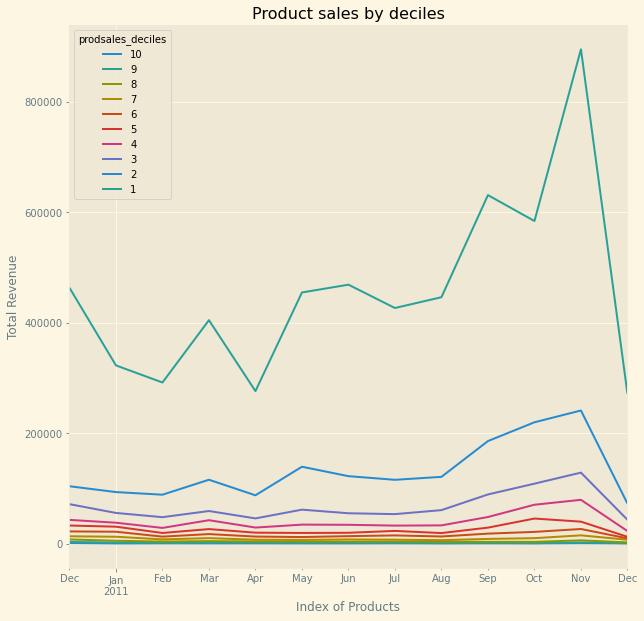

In [26]:
# monthly sales by deciles
sales_data.groupby(['yearmonth','prodsales_deciles']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='prodsales_deciles', 
                                     values='total_revenue', 
                                     index='yearmonth') \
                        .plot(figsize=(10,10)).set(title='Product sales by deciles', 
                   xlabel='Index of Products', 
                   ylabel='Total Revenue')

[Text(0.5, 1.0, 'Product sales by decile groups of lower deciles'),
 Text(0.5, 0, 'Index of Products'),
 Text(0, 0.5, 'Total Revenue')]

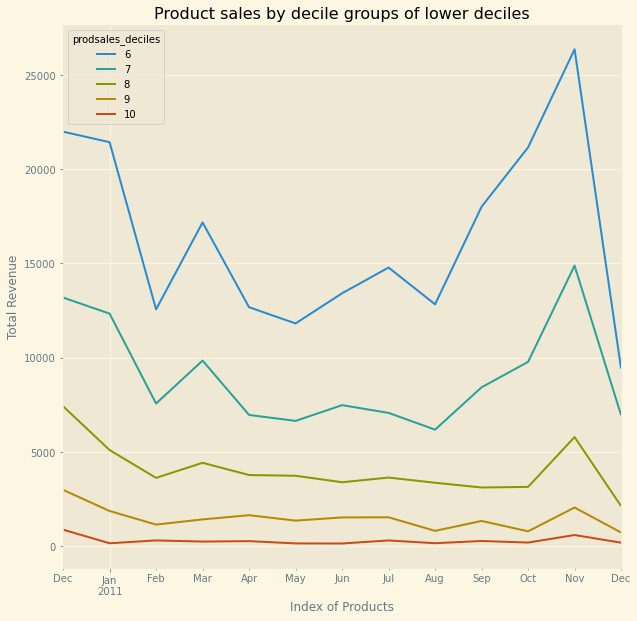

In [27]:
# monthly sales by lower deciles
sales_data.groupby(['yearmonth','prodsales_deciles']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='prodsales_deciles', 
                                     values='total_revenue', 
                                     index='yearmonth')[[6,7,8,9,10]] \
                        .plot(figsize=(10,10)).set(
                                title='Product sales by decile groups of lower deciles', 
                                xlabel='Index of Products', 
                                ylabel='Total Revenue')

We plot sales by decile month to check if there are any products is the lower deciles that have a large flucuation in sales. If there are the we woul see decile lines converging or crossing each other. 

As we want to exclude small products from the dataset, this analysis is done to avoid the situation where there are products that increase significantly in proportion at year end but is excluded from analysis because the percentile analysis is done over the whole period.

Since we do not see significant convergence or crossing of decile lines, we can be confident that the lower decile sales are not significant overall.

In [28]:
# drop transactions of products that are in deciles 6 to 10
sales_data = sales_data[sales_data['prodsales_deciles'] >= 5].copy()

#### Products by Month

In [29]:
product_by_month = sales_data \
                    .groupby(['yearmonth','stockcode_caps'])[['revenue']] \
                    .sum().reset_index()

In [30]:
product_by_month

,yearmonth,stockcode_caps,revenue
0,2010-12,10002,234.41
1,2010-12,10125,90.86
2,2010-12,10133,85.27
3,2010-12,10135,279.02
4,2010-12,11001,136.73
...,...,...,...
20564,2011-12,85227,67.09
20565,2011-12,85231B,30.11
20566,2011-12,85232D,34.77
20567,2011-12,90057,60.00


In [31]:
product_by_month_cross = pd.crosstab(index=product_by_month['yearmonth'],
            columns=product_by_month['stockcode_caps'],
            values=product_by_month['revenue'], 
            aggfunc=sum,
            normalize='index',
           )

In [32]:
sim_matrix_prod_month = cosine_similarity(product_by_month_cross)

In [33]:
month_sim = pd.DataFrame(sim_matrix_prod_month, 
                         columns=product_by_month_cross.index, 
                         index=product_by_month_cross.index)

<AxesSubplot:xlabel='yearmonth', ylabel='yearmonth'>

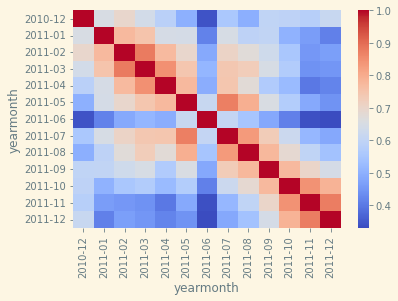

In [34]:
sns.heatmap(month_sim, cmap='coolwarm')

To identify key changes of brands from month to month, we would take the absolute change in sales of each brand divided by total absolute change for all brands.

In [35]:
# key changes month to month
product_by_month_abs = pd.crosstab(index=product_by_month['yearmonth'],
            columns=product_by_month['stockcode_caps'],
            values=product_by_month['revenue'], 
            aggfunc=sum,
           ).fillna(value=0)

In [36]:
# ab

In [37]:
product_by_month_abs_diff = product_by_month_abs.diff(periods=1, axis=0).dropna()

In [38]:
product_by_month_abs_diff.index

PeriodIndex(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
             '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12'],
            dtype='period[M]', name='yearmonth')

In [39]:
len(product_by_month_abs_diff.index)-1

11

In [40]:
product_by_month_abs_diff.iloc[0].sort_values(ascending=False).head(5)

stockcode_caps
21108    6,199.97
85123A   5,367.18
48185    4,616.64
22720    3,745.90
21175    3,704.15
Name: 2011-01, dtype: float64

In [41]:
#Top 10 gainers
for i in product_by_month_abs_diff.index:
    print(product_by_month_abs_diff.loc[i].sort_values(ascending=False).head(5))

stockcode_caps
21108    6,199.97
85123A   5,367.18
48185    4,616.64
22720    3,745.90
21175    3,704.15
Name: 2011-01, dtype: float64
stockcode_caps
21623   6,569.86
22053   3,296.67
22693   3,247.35
22189   2,286.84
47566   2,059.54
Name: 2011-02, dtype: float64
stockcode_caps
22423    6,364.56
47566    4,750.37
85099B   4,502.79
85099F   4,022.18
22386    3,106.46
Name: 2011-03, dtype: float64
stockcode_caps
47556B   2,730.00
23199    2,325.01
23206    2,091.77
22727    1,950.20
22693    1,882.56
Name: 2011-04, dtype: float64
stockcode_caps
47566    8,799.13
23298    8,138.72
85123A   6,292.48
23284    5,729.06
23203    4,695.24
Name: 2011-05, dtype: float64
stockcode_caps
22502   37,410.30
23245    6,509.52
21137    3,970.01
23173    3,849.60
22720    3,547.11
Name: 2011-06, dtype: float64
stockcode_caps
22423    4,311.17
85123A   3,958.15
23297    3,086.88
47566    2,119.38
23296    2,009.53
Name: 2011-07, dtype: float64
stockcode_caps
84879    6,752.76
85099B   4,368.14
23199    

In [42]:
stock_descriptions[stock_descriptions['stockcode_caps']=='22476']

,stockcode_caps,description_new
1304,22476,EMPIRE UNION JACK TV DINNER TRAY


In [43]:
duct_by_month_pct_diff = product_by_month_abs.pct_change(periods=1)

In [44]:
duct_by_month_pct_diff

stockcode_caps,10002,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,...,85185B,85194L,85199S,85206A,85212,85227,85231B,85232D,90057,90200D
yearmonth,,,,,,,,,,,,,,,,,,,,,
2010-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-01,0.24,0.21,0.34,0.75,-0.58,1.76,1.44,2.86,2.33,4.99,...,-0.39,2.57,-0.71,2.85,-0.02,-0.82,-0.88,0.34,-0.69,-0.63
2011-02,-0.84,-1.00,-0.70,-0.39,0.04,-0.46,5.50,-0.76,-0.16,-0.25,...,-0.58,1.29,0.13,1.51,-0.30,4.18,-0.41,0.66,0.18,0.54
2011-03,-0.39,inf,1.03,-0.67,0.55,0.15,0.42,1.56,4.35,2.63,...,3.51,0.01,0.16,-0.15,0.37,-0.56,0.11,-0.87,-1.00,-0.59
2011-04,4.80,-0.29,-0.07,-0.62,-0.34,2.09,-0.32,0.07,-0.50,-0.51,...,-0.58,-0.42,-0.54,-1.00,0.02,-0.27,3.97,2.50,NaN,-0.42
2011-05,-1.00,0.30,-0.57,-0.41,1.67,1.07,1.43,7.57,0.71,2.36,...,0.87,-1.00,-0.52,NaN,-0.53,2.10,-0.94,-0.57,NaN,1.25
2011-06,NaN,-0.84,8.50,2.08,0.55,0.03,-0.27,-0.12,-0.10,-0.64,...,0.49,NaN,3.33,NaN,6.72,-0.06,5.50,1.67,NaN,0.12
2011-07,NaN,9.57,0.55,2.22,-0.03,-0.73,-0.04,-0.38,-0.19,-0.36,...,-0.43,NaN,-0.48,NaN,-0.82,-0.26,-0.40,-1.00,NaN,-0.10
2011-08,NaN,-0.52,-0.10,-0.23,0.72,1.65,-0.51,-0.22,-0.38,-1.00,...,1.19,NaN,-0.06,NaN,0.14,-0.06,0.31,NaN,NaN,-0.33


In [45]:
duct_by_month_pct_diff.loc['2011-01'] \
            .replace([np.inf, -np.inf], np.nan) \
            .dropna().sort_values(ascending=False).head(5)

stockcode_caps
22148   111.76
22228    58.38
22241    27.83
22138    20.44
22220    16.42
Name: 2011-01, dtype: float64

In [46]:
#Top 10 gainers
for i in duct_by_month_pct_diff.index:
    duct_by_month_pct_diff.loc[i].dropna()
    print(duct_by_month_pct_diff.loc[i].sort_values(ascending=False).head(5))

stockcode_caps
10002   NaN
10125   NaN
10133   NaN
10135   NaN
11001   NaN
Name: 2010-12, dtype: float64
stockcode_caps
23230    inf
84796B   inf
21084    inf
23232    inf
23233    inf
Name: 2011-01, dtype: float64
stockcode_caps
22997   inf
22989   inf
22995   inf
22994   inf
21813   inf
Name: 2011-02, dtype: float64
stockcode_caps
23194   inf
21394   inf
10125   inf
21395   inf
23158   inf
Name: 2011-03, dtype: float64
stockcode_caps
23061   inf
23055   inf
23132   inf
23131   inf
23075   inf
Name: 2011-04, dtype: float64
stockcode_caps
23164   inf
51008   inf
22593   inf
35651   inf
22580   inf
Name: 2011-05, dtype: float64
stockcode_caps
22600   inf
23244   inf
23238   inf
23239   inf
23240   inf
Name: 2011-06, dtype: float64
stockcode_caps
23293   inf
22809   inf
22186   inf
23313   inf
22738   inf
Name: 2011-07, dtype: float64
stockcode_caps
23327   inf
23436   inf
22827   inf
23328   inf
22114   inf
Name: 2011-08, dtype: float64
stockcode_caps
23412   inf
23400   inf
22911   inf

Generally the product mix from month to month is quite correlated. The correlation reaches about 0.5 around 3 months. June seems particuarly different from December, and this could be a seasonal impact as well due to diffrent gifts during the summer and winter holidays.

### Analysis of Sales by Customer

In [47]:
# get latest date
latest_date = sales_data['invoicedate'].max()

In [48]:
latest_date

Timestamp('2011-12-09 12:50:00')

In [49]:
# create table of sales by customer
sales_by_cust = sales_data.groupby('customerid').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                unique_products=('stockcode_caps',lambda x: x.nunique()),
                                               ).reset_index()

In [50]:
# 76 customers with zero sales or less
sales_by_cust_zero = sales_by_cust[sales_by_cust['total_revenue']<=0]
sales_by_cust_zero

,customerid,total_revenue,total_qty,unique_products
0,12346,0.00,0,1
89,12454,0.00,0,15
168,12558,0.00,0,10
210,12605,-7.50,-4,3
211,12607,0.00,0,97
...,...,...,...,...
5705,C574288,-14.75,-1,1
5706,C575153,-33.17,-1,1
5707,C577779,-288.00,-288,3
5708,C578097,"-1,208.04",-324,7


In [51]:
# Drop customers that have zero sales from sales_data
sales_data = sales_data[~sales_data['customerid'].isin(sales_by_cust_zero['customerid'])].copy()

In [52]:
# select only customers with sales more than zero
sales_by_cust = sales_by_cust[sales_by_cust['total_revenue']>0].copy()

In [53]:
# calculate recency and number of invoices from positive invoices only
sales_by_cust = sales_by_cust.merge(
                    sales_data[sales_data['revenue']>0].groupby('customerid').agg(
                        num_invoices=('invoiceno', lambda x: x.nunique()),
                        recency=('invoicedate', lambda x: (latest_date - x.max()).days)),
                    on = 'customerid',
                    how = 'left'
                    )

Text(0.5, 1.02, 'Customer RFM distribution')

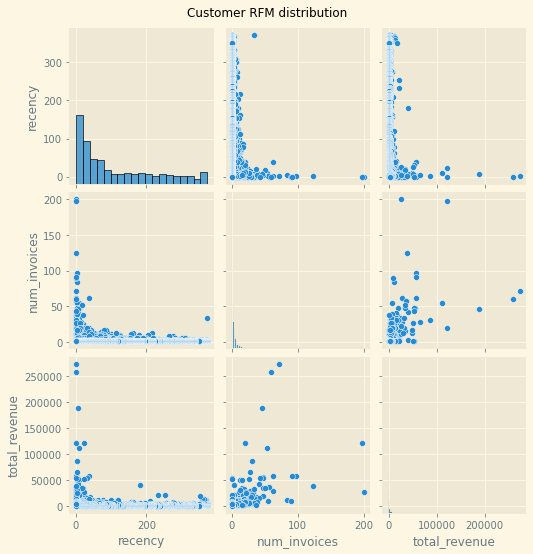

In [54]:
# Display pairplot of customer distribution by Recency, Frequency and Monetary value
g = sns.pairplot(data=sales_by_cust[['recency','num_invoices','total_revenue']])
g.fig.suptitle("Customer RFM distribution", y=1.02)

Most customers have spent within $25,000 and have invoices of around 60 or less.

Recency and Frequency (num_invoices): There are many customers that are very recent, with few number of invoices. Also, they have low in total revenue. We will try to identify customers that are likely new, if they have only purchases that are the most recent and no previous purchasing history.

In [55]:
sales_by_cust['custsales_quntiles'] = pd.qcut(sales_by_cust.total_revenue, 5, labels = [5,4,3,2,1])

In [56]:
sales_by_cust.groupby(pd.qcut(sales_by_cust['total_revenue'], 5, labels = [5,4,3,2,1])) \
                [['total_revenue','total_qty','num_invoices']].sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Customer by Total Sales Quintile')

,total_revenue,total_qty,num_invoices
Customer by Total Sales Quintile,,,
5,0.01,0.01,0.06
4,0.03,0.04,0.08
3,0.07,0.07,0.13
2,0.15,0.15,0.19
1,0.74,0.73,0.53


#### Purchase Frequency: Recency and New customers
For a more relevant metric of customer recency, we would analyze the typical purchase behavior of customers with regards to the timing between purchases

In [57]:
# Create sales data aggregated by customer and invoice
sales_by_cust_invoice = sales_data.groupby(['customerid','invoiceno','invoicedate']) \
                                .agg(total_revenue=('revenue',np.sum),
                                     total_qty=('quantity',np.sum),
                                     unique_products=('stockcode_caps',lambda x: x.nunique()),
                               ).reset_index()

In [58]:
# Count positive invoices per customer
invoice_counts = sales_by_cust_invoice[sales_by_cust_invoice['total_revenue']>0] \
                    .groupby('customerid').agg(
                            count_invoice=('invoiceno',np.size),
                            total_revenue=('total_revenue',np.sum)
                    )
invoice_counts.describe()

,count_invoice,total_revenue
count,"5,634.00","5,634.00"
mean,3.48,"1,704.16"
std,6.78,"7,401.62"
min,1.00,0.42
25%,1.00,227.33
50%,2.00,587.67
75%,4.00,"1,488.72"
max,200.00,"273,944.14"


In [59]:
# Select only positive sales invoices
positive_sales = sales_by_cust_invoice[(sales_by_cust_invoice['total_revenue']>0)]

In [60]:
positive_sales['customerid'].value_counts().index

Index(['12748', '14911', '17841', '13089', '15311', '14606', '12971', '14646',
       '16029', '13408',
       ...
       '16162', '16135', '16141', '16142', '16144', '16147', '16148', '16152',
       '16159', '581498'],
      dtype='object', length=5634)

In [61]:
# Calculate time between each purchases for each customer
time_diff = []
for i in positive_sales['customerid'].value_counts().index:
    invoice_dates = positive_sales[positive_sales['customerid'] == i] \
            .sort_values('invoicedate', ascending=True)['invoicedate'].tolist()
    if len(invoice_dates) > 1:
        for j in range(len(invoice_dates)-1):
            time_diff.append([i, invoice_dates[j+1] - invoice_dates[j]])
    else:
        continue

time_between_purchases = pd.DataFrame(time_diff, 
                                      columns=['customerid','time_between_purchases'])        

<AxesSubplot:xlabel='time_between_purchases', ylabel='Count'>

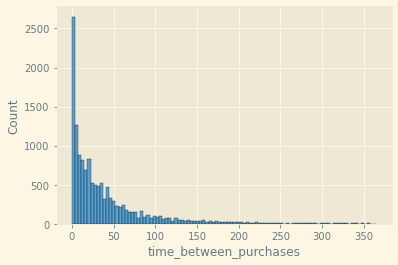

In [62]:
# Plot distribution of time between purchases
sns.histplot(time_between_purchases['time_between_purchases'].dt.days.sort_values())

In [63]:
# Overall statistics for time between purchases
time_between_purchases.groupby(lambda _ : True) \
                    .agg(count_return_purchases=('time_between_purchases',np.size),
                         median_duration=('time_between_purchases',np.median),
                         mean_duration=('time_between_purchases',np.mean),
                         min_duration=('time_between_purchases',np.min),
                         max_duration=('time_between_purchases',np.max)
                        )

,count_return_purchases,median_duration,mean_duration,min_duration,max_duration
True,13981,22 days 02:22:00,40 days 08:19:15.775695586,0 days,365 days 23:34:00


In [64]:
# statistics by customer for time between purchases
cust_purchases_delta = time_between_purchases.groupby('customerid') \
                            .agg(count_return_purchases=('time_between_purchases',np.size),
                                 median_duration=('time_between_purchases',np.median),
                                 mean_duration=('time_between_purchases',np.mean),
                                 min_duration=('time_between_purchases',np.min),
                                 max_duration=('time_between_purchases',np.max)
                               )

In [65]:
# calculate median duration per customer
cust_purchases_delta['median_duration'] = cust_purchases_delta['median_duration'].dt.days

<AxesSubplot:xlabel='count_return_purchases', ylabel='median_duration'>

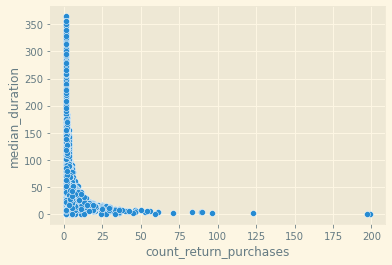

In [66]:
sns.scatterplot(data=cust_purchases_delta, x='count_return_purchases', y='median_duration')

In [67]:
time_between_purchases.describe()

,time_between_purchases
count,13981
mean,40 days 08:19:15.775695586
std,51 days 22:06:12.286367437
min,0 days 00:00:00
25%,6 days 23:09:00
50%,22 days 02:22:00
75%,51 days 20:48:00
max,365 days 23:34:00


In [68]:
# set 50% percentile and 75% percentile as recency score bins. 
# If customer has not bought in 51 days, its likely that they are lost customers 
sales_by_cust['recency_score'] = pd.cut(sales_by_cust.recency, 
                                        bins=[0,22,51,np.infty], 
                                        labels=[3,2,1],
                                       include_lowest=True
                                       )

In [69]:
invoice_recency = positive_sales.groupby('customerid') \
            .agg(total_revenue=('total_revenue',np.sum),
                count_invoice=('invoiceno',np.size),
                earliest_invoice_age=('invoicedate',lambda x: (latest_date - x.min()).days),
                latest_invoice_age=('invoicedate',lambda x: (latest_date - x.max()).days))


In [70]:
invoice_recency['recency_score'] = pd.cut(invoice_recency.latest_invoice_age, 
                                        bins=[0,22,51,np.infty], 
                                        labels=[3,2,1],
                                       include_lowest=True
                                       )

In [71]:
invoice_recency['recency_score_earliest'] = pd.cut(invoice_recency.earliest_invoice_age, 
                                        bins=[0,22,51,np.infty], 
                                        labels=[3,2,1],
                                       include_lowest=True
                                       )

In [72]:
invoice_recency

,total_revenue,count_invoice,earliest_invoice_age,latest_invoice_age,recency_score,recency_score_earliest
customerid,,,,,,
12347,"3,941.24",7,366,1,3,1
12348,"1,376.04",4,357,74,1,1
12349,"1,457.55",1,18,18,3,3
12350,208.90,1,309,309,1,1
12352,"1,385.74",7,296,35,2,1
...,...,...,...,...,...,...
581435,2.10,1,0,0,3,3
581439,"5,362.17",1,0,0,3,3
581492,"6,006.41",1,0,0,3,3


In [73]:
invoice_recency.groupby(['recency_score_earliest','recency_score']) \
            .agg(total_revenue=('total_revenue',np.sum),
                avg_count_invoice=('count_invoice',np.mean),
                avg_earliest_invoice_age=('earliest_invoice_age',np.mean),
                avg_latest_invoice_age=('latest_invoice_age',np.mean))


total_revenue  avg_count_invoice  \
recency_score_earliest recency_score                                     
3                      3                 298,229.06               1.15   
                       2                       0.00                NaN   
                       1                       0.00                NaN   
2                      3                  70,400.38               2.61   
                       2                 324,855.07               1.09   
                       1                       0.00                NaN   
1                      3               5,114,430.46               9.30   
                       2               1,251,492.98               4.91   
                       1               2,541,806.99               1.71   

                                      avg_earliest_invoice_age  \
recency_score_earliest recency_score                             
3                      3                                 11.73   
                       2                                   NaN   
                       1                                   NaN   
2                      3                                 37.30   
                       2                                 36.80   
                       1                                   NaN   
1                      3                                270.64   
                       2                                255.15   
                       1                                230.58   

                                      avg_latest_invoice_age  
recency_score_earliest recency_score                          
3                      3                               11.10  
                       2                                 NaN  
                       1                                 NaN  
2                      3                                8.61  
                       2                               36.25  
                       1                                 NaN  
1                      3                                9.48  
                       2                               34.65  
                       1                              186.37

We will take new customers with earliest purchases less than 22 days as new customers

In [74]:
# Get customerid of new customers
new_cust_list = invoice_recency[(invoice_recency['recency_score_earliest']==3) 
                         & (invoice_recency['recency_score']==3)].index.tolist()

In [75]:
# Create feature to indicate new customer in sales data table
sales_data['new_cust'] = sales_data['customerid'].isin(new_cust_list)
sales_by_cust['new_cust'] = sales_by_cust['customerid'].isin(new_cust_list)

#### RFM Analysis

In [76]:
sales_by_cust['frequency_score'] = pd.qcut(sales_by_cust.num_invoices.rank(method='first'), 
                                           3, 
                                           labels = [1,2,3])

In [77]:
sales_by_cust['monetary_score'] = pd.qcut(sales_by_cust.total_revenue.rank(method='first'), 
                                          3, 
                                          labels = [1,2,3])

In [78]:
sales_by_cust['RFM_group'] = sales_by_cust[['recency_score',
                                            'frequency_score',
                                            'monetary_score']].astype('str').agg(''.join, axis=1)

In [79]:
sales_by_cust.groupby('RFM_group').agg(cust_count=('customerid',np.size),
                                        total_revenue=('total_revenue',np.sum),
                                        avg_recency=('recency',np.mean),
                                        avg_invoices=('num_invoices',np.mean),
                                        avg_revenue=('total_revenue',np.mean),
                                       new_cust = ('new_cust',np.sum)
                                               ).reset_index().sort_values(by='total_revenue',
                                                                           ascending=False)

,RFM_group,cust_count,total_revenue,avg_recency,avg_invoices,avg_revenue,new_cust
26,333,741,"4,778,347.28",8.41,12.23,"6,448.51",3
17,233,276,"990,225.17",34.12,7.14,"3,587.77",0
8,133,244,"638,005.69",100.84,5.44,"2,614.78",0
5,123,310,"600,825.58",146.11,1.32,"1,938.15",0
2,113,150,"398,451.57",279.96,1.00,"2,656.34",0
4,122,467,"285,956.29",159.83,1.67,612.33,0
14,223,71,"274,421.31",36.18,1.52,"3,865.09",0
23,323,77,"270,530.04",10.31,1.52,"3,513.38",49
1,112,433,"231,173.39",207.08,1.00,533.89,0
25,332,215,"161,656.13",10.80,4.25,751.89,2


In [80]:
sales_by_cust

,customerid,total_revenue,total_qty,unique_products,num_invoices,recency,custsales_quntiles,recency_score,new_cust,frequency_score,monetary_score,RFM_group
0,12347,"3,941.24",2170,88,7,1,1,3,False,3,3,333
1,12348,"1,376.04",2260,19,4,74,2,1,False,3,3,133
2,12349,"1,457.55",630,72,1,18,2,3,True,1,3,313
3,12350,208.90,142,11,1,309,4,1,False,1,1,111
4,12352,"1,265.41",463,57,7,35,2,2,False,3,3,233
...,...,...,...,...,...,...,...,...,...,...,...,...
5629,581435,2.10,1,1,1,0,5,3,True,2,1,321
5630,581439,"5,362.17",1606,552,1,0,1,3,True,2,3,323
5631,581492,"6,006.41",1741,582,1,0,1,3,True,2,3,323
5632,581497,"3,217.20",654,56,1,0,1,3,True,2,3,323


In [81]:
sales_by_cust.groupby(['recency_score','frequency_score']).agg(
                                            num_cust=('customerid',np.size),
                                            num_new_cust=('new_cust',np.sum),
                                            maxinvoice=('num_invoices',np.max),
                                            mininvoice=('num_invoices',np.min),
                                            avg_recency=('recency',np.mean),
                                            avg_invoices=('num_invoices',np.mean),
                                            total_revenue=('total_revenue',np.sum))

num_cust  num_new_cust  maxinvoice  mininvoice  \
recency_score frequency_score                                                   
3             1                     150           150           1           1   
              2                     339           116           3           1   
              3                     967             7         200           3   
2             1                     230             0           1           1   
              2                     286             0           3           1   
              3                     431             0          62           3   
1             1                    1498             0           1           1   
              2                    1253             0           3           1   
              3                     480             0          34           3   

                               avg_recency  avg_invoices  total_revenue  
recency_score frequency_score                                            
3             1                      12.55          1.00      42,054.65  
              2                      10.75          1.81     379,814.52  
              3                       8.95         10.36   4,942,580.72  
2             1                      36.56          1.00      79,407.35  
              2                      35.77          1.74     360,371.75  
              3                      34.21          5.95   1,100,611.03  
1             1                     231.61          1.00     764,017.33  
              2                     159.77          1.45     940,379.73  
              3                     114.61          4.65     785,582.98

In [82]:
sales_by_cust.loc[(sales_by_cust['recency_score'] == 3) & 
            (sales_by_cust['frequency_score'] >= 2) &
            (sales_by_cust['new_cust'] == False),'cust_matrix'] = 'star_cust'

In [83]:
sales_by_cust.loc[(sales_by_cust['new_cust'] == True),'cust_matrix'] = 'new_cust'

In [84]:
sales_by_cust.loc[(sales_by_cust['recency_score'] == 2) & 
                (sales_by_cust['frequency_score'] >= 2) &
                (sales_by_cust['new_cust'] == False),'cust_matrix'] = 'problem_cust'

In [85]:
sales_by_cust.loc[((sales_by_cust['recency_score'] == 1) | 
            (sales_by_cust['frequency_score'] == 1)) &
                (sales_by_cust['new_cust'] == False),'cust_matrix'] = 'lost_cust'

In [86]:
sales_by_cust.groupby(['cust_matrix'],dropna=False).agg(
                                            num_cust=('customerid',np.size),
                                            num_new_cust=('new_cust',np.sum),
                                            maxinvoice=('num_invoices',np.max),
                                            mininvoice=('num_invoices',np.min),
                                            avg_recency=('recency',np.mean),
                                            avg_invoices=('num_invoices',np.mean),
                                            total_revenue=('total_revenue',np.sum))

,num_cust,num_new_cust,maxinvoice,mininvoice,avg_recency,avg_invoices,total_revenue
cust_matrix,,,,,,,
lost_cust,3461,0,34,1,176.41,1.67,"2,569,387.38"
new_cust,273,273,6,1,11.10,1.15,"297,780.98"
problem_cust,717,0,62,1,34.83,4.27,"1,460,982.78"
star_cust,1183,0,200,2,9.42,8.85,"5,066,668.91"


In [87]:
sales_by_cust

,customerid,total_revenue,total_qty,unique_products,num_invoices,recency,custsales_quntiles,recency_score,new_cust,frequency_score,monetary_score,RFM_group,cust_matrix
0,12347,"3,941.24",2170,88,7,1,1,3,False,3,3,333,star_cust
1,12348,"1,376.04",2260,19,4,74,2,1,False,3,3,133,lost_cust
2,12349,"1,457.55",630,72,1,18,2,3,True,1,3,313,new_cust
3,12350,208.90,142,11,1,309,4,1,False,1,1,111,lost_cust
4,12352,"1,265.41",463,57,7,35,2,2,False,3,3,233,problem_cust
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5629,581435,2.10,1,1,1,0,5,3,True,2,1,321,new_cust
5630,581439,"5,362.17",1606,552,1,0,1,3,True,2,3,323,new_cust
5631,581492,"6,006.41",1741,582,1,0,1,3,True,2,3,323,new_cust
5632,581497,"3,217.20",654,56,1,0,1,3,True,2,3,323,new_cust


Merge customer data for export

In [88]:
customer_location = customer_location.merge(sales_by_cust[['customerid','recency_score',
                                        'frequency_score','monetary_score','cust_matrix']], 
                                        on='customerid', 
                                        how='left')

#### Sales by month by RFM segments

In [89]:
sales_data

,invoiceno,stockcode_caps,quantity,unitprice,customerid,domestic,invoicedate,test,revenue,yearmonth,quarter,week,prodsales_deciles,new_cust
0,536365,85123A,6,2.55,17850,True,2010-12-01 08:26:00,False,15.30,2010-12,2010Q4,2010-11-29/2010-12-05,1,False
1,536365,71053,6,3.39,17850,True,2010-12-01 08:26:00,False,20.34,2010-12,2010Q4,2010-11-29/2010-12-05,1,False
2,536365,84406B,8,2.75,17850,True,2010-12-01 08:26:00,False,22.00,2010-12,2010Q4,2010-11-29/2010-12-05,1,False
3,536365,84029G,6,3.39,17850,True,2010-12-01 08:26:00,False,20.34,2010-12,2010Q4,2010-11-29/2010-12-05,1,False
4,536365,84029E,6,3.39,17850,True,2010-12-01 08:26:00,False,20.34,2010-12,2010Q4,2010-11-29/2010-12-05,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536488,581578,22993,12,1.25,12713,False,2011-12-09 12:16:00,True,15.00,2011-12,2011Q4,2011-12-05/2011-12-11,1,True
536489,581578,22907,12,0.85,12713,False,2011-12-09 12:16:00,True,10.20,2011-12,2011Q4,2011-12-05/2011-12-11,2,True
536490,581578,22908,12,0.85,12713,False,2011-12-09 12:16:00,True,10.20,2011-12,2011Q4,2011-12-05/2011-12-11,2,True
536491,581578,23215,12,2.08,12713,False,2011-12-09 12:16:00,True,24.96,2011-12,2011Q4,2011-12-05/2011-12-11,1,True


In [90]:
sales_data = sales_data.merge(sales_by_cust[['customerid',
                                             'recency_score',
                                             'frequency_score',
                                             'monetary_score',
                                             'cust_matrix']], 
                              how='left',
                             on='customerid',)

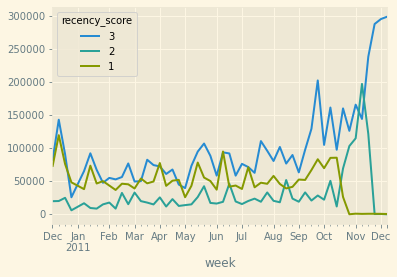

In [91]:
sales_recency = sales_data.groupby(['week','recency_score']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='recency_score', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

Overall, there is a upward spike in sales in November, presumably in preparation for the Christmas season. Theres a significant drop in sales from recency group 1 in Nov, given that the sales was pretty constant throught the year just over $20k a month, but it dropped off quickly in November. Further analysis would be done to see if there were any significant customers that were lost in this segment.

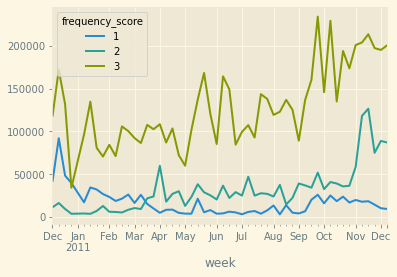

In [92]:
sales_frequency = sales_data.groupby(['week','frequency_score']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='frequency_score', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

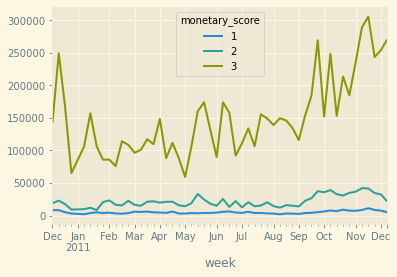

In [93]:
sales_monetary = sales_data.groupby(['week','monetary_score']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='monetary_score', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

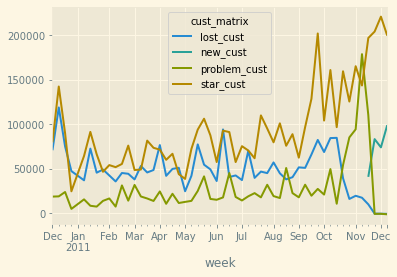

In [94]:
sales_monetary = sales_data.groupby(['week','cust_matrix']) \
                        .agg(total_revenue=('revenue',np.sum)) \
                        .reset_index() \
                        .pivot_table(columns='cust_matrix', 
                                     values='total_revenue', 
                                     index='week') \
                        .plot()

#### Returns

In [95]:
# negative sales before and after

We would drop lost customers from the dataset for modelling

In [96]:
sales_data = sales_data[sales_data['cust_matrix'] != 'lost_cust']
sales_data

,invoiceno,stockcode_caps,quantity,unitprice,customerid,domestic,invoicedate,test,revenue,yearmonth,quarter,week,prodsales_deciles,new_cust,recency_score,frequency_score,monetary_score,cust_matrix
504,536370,22728,24,3.75,12583,False,2010-12-01 08:45:00,False,90.00,2010-12,2010Q4,2010-11-29/2010-12-05,1,False,3,3,3,star_cust
505,536370,22727,24,3.75,12583,False,2010-12-01 08:45:00,False,90.00,2010-12,2010Q4,2010-11-29/2010-12-05,1,False,3,3,3,star_cust
506,536370,22726,12,3.75,12583,False,2010-12-01 08:45:00,False,45.00,2010-12,2010Q4,2010-11-29/2010-12-05,1,False,3,3,3,star_cust
507,536370,21883,24,0.65,12583,False,2010-12-01 08:45:00,False,15.60,2010-12,2010Q4,2010-11-29/2010-12-05,5,False,3,3,3,star_cust
508,536370,10002,48,0.85,12583,False,2010-12-01 08:45:00,False,40.80,2010-12,2010Q4,2010-11-29/2010-12-05,5,False,3,3,3,star_cust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480412,581578,22993,12,1.25,12713,False,2011-12-09 12:16:00,True,15.00,2011-12,2011Q4,2011-12-05/2011-12-11,1,True,3,1,2,new_cust
480413,581578,22907,12,0.85,12713,False,2011-12-09 12:16:00,True,10.20,2011-12,2011Q4,2011-12-05/2011-12-11,2,True,3,1,2,new_cust
480414,581578,22908,12,0.85,12713,False,2011-12-09 12:16:00,True,10.20,2011-12,2011Q4,2011-12-05/2011-12-11,2,True,3,1,2,new_cust
480415,581578,23215,12,2.08,12713,False,2011-12-09 12:16:00,True,24.96,2011-12,2011Q4,2011-12-05/2011-12-11,1,True,3,1,2,new_cust


### Export to CSV

In [97]:
selected_columns = ['invoiceno', 'stockcode_caps', 'quantity', 'unitprice', 'customerid']

In [98]:
sales_data[selected_columns].to_csv('../data/processed_sales.csv', index=False)

In [99]:
customer_location.to_csv('../data/processed_customer.csv', index=False)